In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from  nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from wordcloud import WordCloud, STOPWORDS
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import unidecode
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from googletrans import Translator
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import seaborn as sns


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


/Users/Michi/anaconda/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# Edit this with the path to your data

tweet_file = '/Users/Michi/Google Drive/formation_data_science/hate-speech-and-offensive-language-master/data/labeled_data.csv'

tw_data = pd.read_csv(tweet_file)

tw_data.rename(columns={'tweet': 'Texte'}, inplace=True)

# To do test more quicky, use only a small subsample uncommenting the following line
# tw_data = tw_data.sample(2000, random_state=123)

tw_data.head(3)


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,Texte
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [3]:
tw_data.shape

(24783, 7)

In [4]:
tw_data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

# Feature preparation. Add features, clean tweets, sentiment analysis, vectorization

Clean Text

In [3]:

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    stemmer = EnglishStemmer()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens


def tweet_cleaner(text, my_dict):
    
    # fixes encoding problem (MICHELE)
    if type(text)!=unicode:
        try: 
            text= unicode(text,'utf-8')
        except UnicodeDecodeError: 
            text= unicode(text,'latin-1')
    
    tok = WordPunctTokenizer()

    pat1 = r'@[A-Za-z0-9_]+'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
 
    text = unidecode.unidecode(text)
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    letters_only = re.sub("[^a-zA-Z]", " ", lower_case)
    
    # replace common abbreviations with full expression (MICHELE)
    for word in my_dict:
        letters_only = re.sub(word, my_dict[word], letters_only)

    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()




Tf-idf

In [30]:

def generate_stopwords():
    stopwords_en = nltk.corpus.stopwords.words("english")
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_en+stopwords_fr
    other_exclusions = ["#ff", "ff", "rt"]
    stop_words.extend(other_exclusions)
    return stop_words



def get_tfidf_frequencies(data):

    # Note: Equivalent to CountVectorizer followed by TfidfTransformer
    tfidf = TfidfVectorizer(sublinear_tf=True, 
                            tokenizer=tokenize,
                            preprocessor= lambda x: tweet_cleaner(x, my_dict),
                            ngram_range=(1, 3),
                            use_idf=True,
                            smooth_idf=False,
                            norm=None,
                            decode_error='replace',
                            max_features=10000,
                            min_df=5,
                            max_df=0.75,
                            stop_words=generate_stopwords())

    features = tfidf.fit_transform(data).toarray()
    sum_words = features.sum(axis=0)
    words_freq ={word: sum_words[idx] for word,idx in tfidf.vocabulary_.items()}
    vocab = {v:i for i, v in enumerate(tfidf.get_feature_names())}

    return features, words_freq, vocab

In [31]:
my_dict={"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

features, words_freq, vocab = get_tfidf_frequencies(tw_data.Texte)

features.shape

(24783, 6767)

In [32]:
M=features
M.shape

(24783, 6767)

# ML


Suggestions to go on:
- try methods for feature reduction (PCA, ....)
- try different algorithms, tune parameters (grid search) & compare results
- try to output probabilities & signal tweet only if P > some_value

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [34]:
tw_data['Label_id']=tw_data['class']#.factorize()[0]
label_id_df_fr = tw_data[['class', 'Label_id']].drop_duplicates().sort_values('Label_id')
label_to_id_fr = dict(label_id_df_fr.values)

y = tw_data['Label_id'].as_matrix()

print('Label dictionary:')
#print(label_to_id_fr)
dict_labels={'0':'Hate','1':'Offensive','2':'Neither'}
print(dict_labels)

Label dictionary:
{'1': 'Offensive', '0': 'Hate', '2': 'Neither'}


In [35]:
X_train, X_test, y_train, y_test = train_test_split(M, y, random_state=42, test_size=0.1)

In [36]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [37]:
param_grid = [{}] # Optionally add parameters here

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [38]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   2.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   1.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s finished


In [39]:
y_preds = model.predict(X_test)

In [40]:
print(classification_report( y_test, y_preds ))

             precision    recall  f1-score   support

          0       0.44      0.56      0.50       164
          1       0.96      0.91      0.93      1905
          2       0.82      0.94      0.88       410

avg / total       0.90      0.89      0.90      2479



 My preprocess, their tokenizer

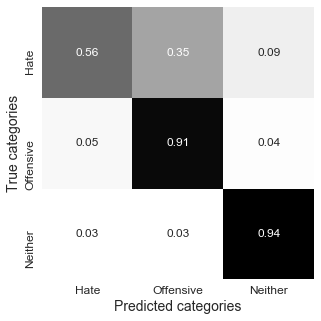

In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions,
                            index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,
            annot_kws={"size": 12},cmap='gist_gray_r',
            cbar=False, square=True,fmt='.2f');
plt.ylabel(r'True categories',fontsize=14);
plt.xlabel(r'Predicted categories',fontsize=14);
plt.tick_params(labelsize=12);




# DataViz. Most frequent wrds/n-grams, correlation matrix, wordcloud

Wordcloud

In [49]:
tw_data_bad = tw_data.loc[(tw_data['class']==0) | (tw_data['class']==1)]
tw_data_good = tw_data.loc[(tw_data['class']==2)]


features_bad_tfidf, words_freq_bad_tfidf, vocab_bad = get_tfidf_frequencies(tw_data_bad.Texte)
features_good_tfidf, words_freq_good_tfidf, vocab_good = get_tfidf_frequencies(tw_data_good.Texte)

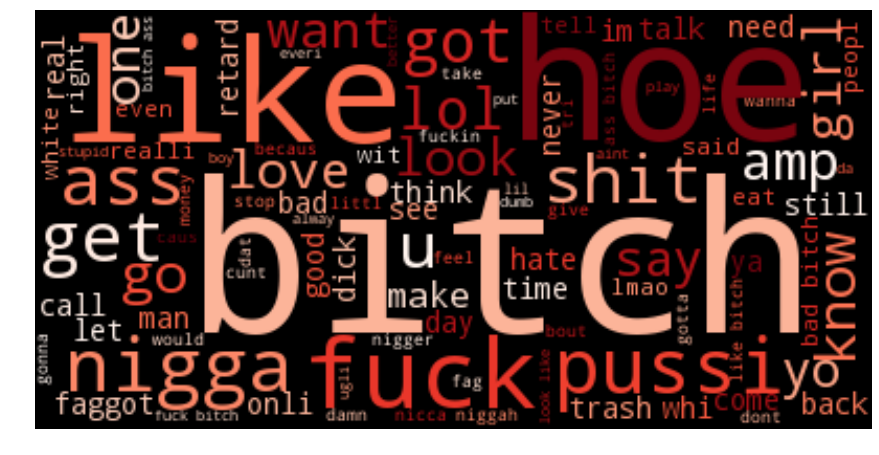

In [50]:
wc_bad_tfidf = WordCloud( background_color='black', max_words=100, 
                   stopwords=generate_stopwords(), max_font_size=100,
                  colormap="Reds")
   
plt.figure(figsize= (15,10));
wc_bad_tfidf.generate_from_frequencies(words_freq_bad_tfidf);
plt.axis("off");
plt.margins(x=0, y=0);
plt.imshow(wc_bad_tfidf, interpolation="bilinear");



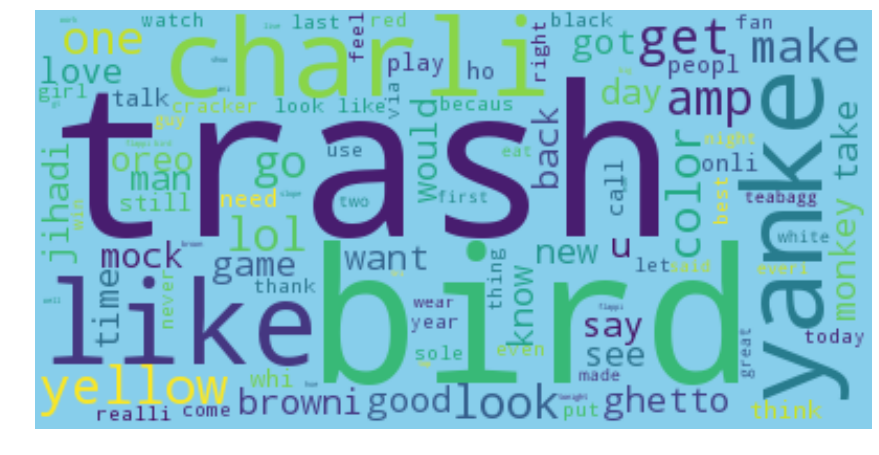

In [51]:
wc_good_tfidf = WordCloud( background_color='skyblue', max_words=100, 
                   stopwords=generate_stopwords(), max_font_size=100)
   
plt.figure(figsize= (15,10));
wc_good_tfidf.generate_from_frequencies(words_freq_good_tfidf);
plt.axis("off");
plt.margins(x=0, y=0);
plt.imshow(wc_good_tfidf, interpolation="bilinear");



Plot correlation matrix between sentiment and label 

In [48]:
def my_trans(x):
    translator = Translator()
    try: tr = translator.translate(x, src='fr', dest='en').text
    except ValueError: tr = ''
    return tr


def add_sentiment(df, col):
    
     
    dict_en={"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

    vectorizer = TfidfVectorizer(sublinear_tf=True, 
                            tokenizer=tokenize,
                            preprocessor= lambda x: preprocess(x),
                            min_df=10,
                            max_df=0.5,
                            norm='l2', 
                            encoding='utf-8', 
                            stop_words=generate_stopwords(),
                            use_idf=True)

    print('Creating vectorizer......')
    X = vectorizer.fit_transform(df[col])
    sid = SentimentIntensityAnalyzer()
    df['sentiment_compound_polarity']=df[col].apply(lambda x:sid.polarity_scores(x)['compound'])
    df['sentiment_neutral']=df[col].apply(lambda x:sid.polarity_scores(x)['neu'])
    df['sentiment_negative']=df[col].apply(lambda x:sid.polarity_scores(x)['neg'])
    df['sentiment_pos']=df[col].apply(lambda x:sid.polarity_scores(x)['pos'])
    df['sentiment_type']=''
    df.loc[df.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
    df.loc[df.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
    df.loc[df.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
    df = df.drop(['sentiment_compound_polarity','sentiment_neutral','sentiment_negative','sentiment_pos' ],axis=1)
    
    return df

In [30]:


def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def sentiment_correlation(df, cols):
    print('Creating correlation matrix......')
    for col in cols:
        df = create_dummies(df, col)
    df_corr  = df.iloc[:,df.shape[1]-6:df.shape[1]]#.drop('Label_id')

    corrmat = df_corr.corr()
    f, ax = plt.subplots(figsize=(12, 9)) # this only to make a larger figure
    #sns.heatmap(corrmat, vmax=.8, square=True);
    sns.set(font_scale=1.25)
    colsInd = corrmat.index
    hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=colsInd.values, xticklabels=colsInd.values)
    plt.show()
        
    return corrmat


Translation finished. Creating vectorizer......


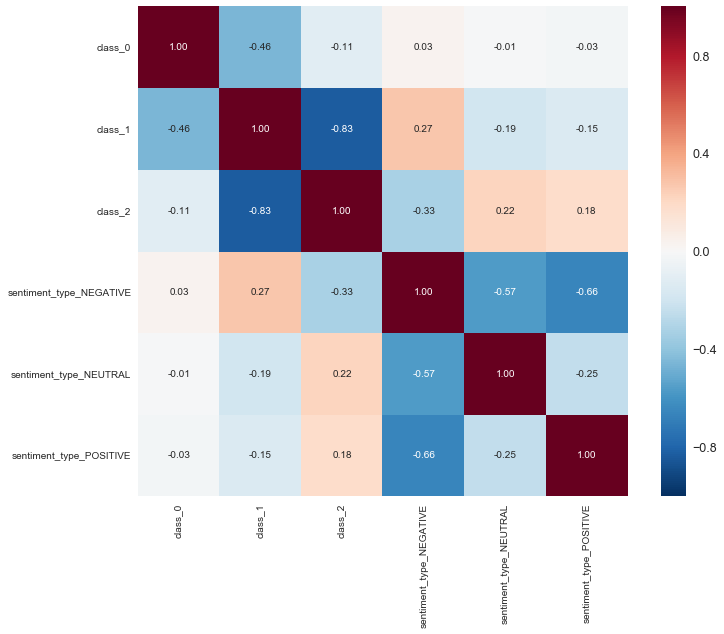

,class_0,class_1,class_2,sentiment_type_NEGATIVE,sentiment_type_NEUTRAL,sentiment_type_POSITIVE
class_0,1.000000,-0.458365,-0.111187,0.032677,-0.011297,-0.028121
class_1,-0.458365,1.000000,-0.832289,0.274329,-0.194488,-0.145159
class_2,-0.111187,-0.832289,1.000000,-0.327130,0.224519,0.179853
sentiment_type_NEGATIVE,0.032677,0.274329,-0.327130,1.000000,-0.566400,-0.659216
sentiment_type_NEUTRAL,-0.011297,-0.194488,0.224519,-0.566400,1.000000,-0.246328
sentiment_type_POSITIVE,-0.028121,-0.145159,0.179853,-0.659216,-0.246328,1.000000


In [31]:

tw_data = add_sentiment(tw_data, 'Texte')
sentiment_correlation(tw_data, ['class', 'sentiment_type'])